# 0.加载模块 Load module


In [1]:
# 导入所需的库
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import re
import time
import json
import subprocess
import requests
from requests.adapters import HTTPAdapter, Retry

import pubchempy as pcp
from pubchempy import PubChemHTTPError
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

import torch
from torch import nn
from torch.nn import functional as F
import transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
)
from torch.utils.data import Dataset, DataLoader

from d2l import torch as d2l
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
)

import sys
import seaborn as sns
# 设置调色板
# Set palette
sns.set_palette("muted")
# 设置环境变量为false
# Set the environment variable to false
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 导入模型文件
# Import model files
sys.path.append('.//code')
from model import Net, NetESM

In [2]:
# 定义关键词enzyme的原始数据文件
# Define the original file for keyword "enzyme"
DATE = "20240611"
path_source_enzyme = f"../data/data_reviewed_enzyme_{DATE}.tsv"
path_enzyme_tem = path_source_enzyme.replace(f'{DATE}', f'{DATE}_tem')
path_enzyme_SMILES = path_source_enzyme.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义额外的测试数据的原始数据文件
# Define the original files of additional test data
path_source_EC11 = f"../data/data_reviewed_EC11_{DATE}.tsv"
path_source_EC27 = f"../data/data_reviewed_EC27_{DATE}.tsv"
path_source_EC31 = f"../data/data_reviewed_EC31_{DATE}.tsv"
path_source_EC42 = f"../data/data_reviewed_EC42_{DATE}.tsv"
path_source_EC56 = f"../data/data_reviewed_EC56_{DATE}.tsv"
path_source_EC63 = f"../data/data_reviewed_EC63_{DATE}.tsv"
path_source_EC71 = f"../data/data_reviewed_EC71_{DATE}.tsv"
path_source_CA_unreviewed_5 = f'../data/data_unreviewed_CA_5_{DATE}.tsv'

# 定义具有Catalytic Activity的原始数据文件，DATE后添加01，来区分源于path_source_enzyme的训练集、验证集和测试集文件
# Define the original data file with Catalytic Activity, add '01' after DATE to distinguish the training set, validation set and test set files originating from path_source_enzyme
DATE = "20240611"
DATE += '01'
path_source_CA = f"../data/data_reviewed_CA_{DATE}.tsv"
path_CA_tem = path_source_CA.replace(f'{DATE}', f'{DATE}_tem')
path_CA_SMILES = path_source_CA.replace(f'{DATE}', f'{DATE}_SMILES')

# 定义提取的同一个催化反应的底物/产物的最大数量
# Define the maximum number of substrates/products extracted from the same catalytic reaction
NUMBER_REACTION = 10

# 定义序列聚类的一致性阈值，比如0.8,0.6,0.4
# Define the sequence identity threshold for sequence clustering, e.g., 0.8, 0.6, 0.4
SEQ_IDENTITY = 0.80
# 定义序列聚类的文件
# Define the sequence clustering files
path_infile_fasta = f"../data/review_sequence_{DATE}.fasta"
path_outfile_fasta = f"../data/review_sequence_{DATE}_cdhit_{int(SEQ_IDENTITY*100)}"
CLSTR_FILE = path_outfile_fasta + ".clstr"
path_train_fasta = f"../data/review_sequence_train_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"
path_test_fasta = f"../data/review_sequence_test_{DATE}_{int(SEQ_IDENTITY*100)}.fasta"

# 定义训练集、验证集和测试集文件
# Define the files of training set, validation set, and testing set
path_train_data = f"../data/train_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_valid_data = f"../data/valid_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data = f"../data/test_data_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_80_100 = f"../data/test_data_80_100_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_60_80 = f"../data/test_data_60_80_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_40_60 = f"../data/test_data_40_60_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"
path_test_data_0_40 = f"../data/test_data_0_40_{DATE}_{int(SEQ_IDENTITY*100)}.tsv"

定义共用的函数 Define shared functions

In [3]:
# 初始化分子量缓存字典
# Initialize molecular weight cache dictionary
molecular_weight_cache = {}

def calculate_molecular_weight(smiles):
    """
    计算smiles分子的分子量
    Calculate the molecular weight
    """
    # 如果元素为空
    # If the element is empty
    if not smiles:
        return -1
    # 如果元素在字典中
    # If the element is in the dictionary
    elif smiles in molecular_weight_cache:
        mw = molecular_weight_cache[smiles]
    # 如果元素不在字典中
    # If the element is not in the dictionary
    else:
        mol = Chem.MolFromSmiles(smiles)
        try:
            mw = Descriptors.ExactMolWt(mol)
        except:
            try:
                # 使用pubchempy的get_compounds函数，根据SMILES字符串搜索PubChem Compound数据库，返回一个Compound对象的列表
                # Use pubchempy's get_compounds function to search the PubChem Compound database based on the SMILES string and return a list of Compound objects.
                compounds = pcp.get_compounds(smiles, "smiles")
                # 如果搜索成功，获取第一个Compound对象的分子量
                # If search success, get the molecular weight of the first Compound object
                mw = float(compounds[0].molecular_weight)
            # 如果搜索失败，将分子量设为0
            # If search fails, set the molecular weight to 0
            except:
                mw = 0
                print("error:", smiles)
        molecular_weight_cache[smiles] = mw
    return mw


def sort_smiles_by_mw(smiles_arr):
    '''
    将smiles_arr数组按照分子量由大到小排序
    Sort the smiles_arr array from large to small molecular weight
    '''
    mol_info = [(smiles, calculate_molecular_weight(smiles))
                for smiles in smiles_arr]
    mol_info.sort(key=lambda x: x[1], reverse=True)
    return np.array([x[0] for x in mol_info])

def load_json(path):
    ''' 
    从json文件中读取内容
    Read content from json file
    '''
    with open(path, "r") as file:
        name_to_smiles_cache = json.load(file)
    return name_to_smiles_cache

def save_json(dict,path):
    '''
    保存json文件
    Save json file
    '''
    with open(path, "w") as file:
        json.dump(dict, file)

def df_to_smiles(df, name_to_smiles_cache={}):
    '''
    将分子转化为SMILES字符串，并添加至原始dataframe
    Convert the molecule into SMILES strings and add it to the original dataframe
    '''
    df.replace(np.nan, "", inplace=True)
    substrate_product_smiles = [
        [handle_name_to_smiles(name, name_to_smiles_cache) for name in row]
        for row in df.iloc[:, 1:].values
    ]
    return (
        pd.merge(
            df,
            pd.DataFrame(substrate_product_smiles, columns=df.columns[1:]),
            left_index=True,
            right_index=True,
        ),
        name_to_smiles_cache,
    )

def handle_name_to_smiles(name, name_to_smiles_cache, retries=10):
    for _ in range(retries):
        try:
            return name_to_smiles(name, name_to_smiles_cache)
        except PubChemHTTPError as e:
            print(f"PubChemHTTPError: {e}, Retrying after 1 seconds...")
            time.sleep(1)
    return None


def name_to_smiles(name, name_to_smiles_cache, mode=0):
    '''
    将化学分子名称转化为SMILES字符串
    Convert chemical molecule names into SMILES strings
    '''
    smiles = None
    name = str(name).strip()
    if name in name_to_smiles_cache:
        return name_to_smiles_cache[name]
    elif name:
        results = pcp.get_compounds(name, "name")
        if results:
            smiles = results[0].canonical_smiles
            time.sleep(0.1)
            if mode == 1:
                smiles = results[0].isomeric_smiles
    name_to_smiles_cache[name] = smiles
    return smiles

def get_test_data(path, data, cols=['Sequence']):
    '''
    获取去重data相同列之后的测试数据
    Obtain test data after deduplicating the same columns of data
    '''
    # 读取数据集
    # Read the dataset
    if path.endswith(".csv"):
        test_data = pd.read_csv(path)
    elif path.endswith(".tsv"):
        test_data = pd.read_csv(path, sep="\t")
    elif path.endswith(".xlsx"):
        test_data = pd.read_excel(path)
    test_data.replace(np.nan, "", inplace=True)

    test_data = test_data[
        ~test_data[cols].apply(
            tuple, axis=1).isin(
                data[cols].apply(tuple, axis=1)
            )
    ]
    test_data.drop_duplicates(inplace=True)
    test_data.reset_index(inplace=True, drop=True)
    return test_data

# 6.模型预测 Model prediction


In [4]:
# 定义常量
NUMBER_LABEL = 3
BATCH_SIZE = 8*2  # 批次大小
MAX_LEN_MOL = 256  # 底物分子序列最大长度
MAX_LEN_SEQ = 1573  # 氨基酸序列最大长度，序列长度的98%分位数

# 检查是否有可用的GPU，如果有，将设备设置为GPU，否则设置为CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 如果有多个GPU，选择其中一个进行训练
if torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")

# 定义蛋白语言模型和化学分子语言模型的模型和分词器，并将它们移动到设备上
prot_bert_tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert")
prot_bert_model = AutoModel.from_pretrained("Rostlab/prot_bert")
# ESM2_t33_tokenizer = AutoTokenizer.from_pretrained(
#     "facebook/esm2_t33_650M_UR50D")
# ESM2_t33_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
chemBERTa_MTR_tokenizer = AutoTokenizer.from_pretrained(
    "DeepChem/ChemBERTa-77M-MTR")
chemBERTa_MTR_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
# chemBERTa_MLM_tokenizer = AutoTokenizer.from_pretrained(
#     "DeepChem/ChemBERTa-77M-MLM")
# chemBERTa_MLM_model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# 读取数据集
# PATH_SMILES = path_enzyme_SMILES # 39k数据
PATH_SMILES = path_CA_SMILES # 151k数据
data01 = pd.read_csv(PATH_SMILES, sep="\t")
data01.replace(np.nan, "", inplace=True)
data01

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_product1_y,reaction1_product2_y,reaction1_product3_y,reaction1_product4_y,reaction1_product5_y,reaction1_product6_y,reaction1_product7_y,reaction1_product8_y,reaction1_product9_y,reaction1_product10_y
0,AAAAAGRGRSFSPAAPAPSSVRLPGRQAPAPAAASALAVEADPAAD...,GTP,IMP,L-aspartate,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,C1=NC2=C(N1C3C(C(C(O3)COP(=O)(O)OP(=O)(O)O)O)O...,[O-]P(=O)([O-])[O-],[H+],,,,,,
1,AAAQRRQNDSSVFLAIMVAAAVESESSLTDGDAGALLLQDISEWDE...,H2O2,,,,,,,,,...,O=O,O,,,,,,,,
2,AADIFAKFKTSMEVK,coenzyme B,methyl-coenzyme M,,,,,,,,...,CC(C(C(=O)[O-])NC(=O)CCCCCCSSCCS(=O)(=O)[O-])O...,C,,,,,,,,
3,AAGGIGQALALLLKNRLPAGSDLALYDIAPVTPGVAADLSHIPTPV...,(S)-malate,NAD(+),,,,,,,,...,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,C(C(=O)C(=O)O)C(=O)O,[H+],,,,,,,
4,AAGRGAWVRTWAPLAMAAKVDLSTSTDWKEAKSFLKGLSDKQREEH...,2''-O-acetyl-ADP-D-ribose,H2O,,,,,,,,...,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,CC(=O)[O-],[H+],,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151395,YYTPEYKTKDTDILAAFRMTPQPGVPAEEAGAAVAAESSTGTWTTV...,(2R)-3-phosphoglycerate,H(+),,,,,,,,...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,C(=O)=O,O,,,,,,,
151396,YYTPEYKTKDTDILAAFRMTPQPGVPAEEAGAAVAAESSTGTWTTV...,"D-ribulose 1,5-bisphosphate",O2,,,,,,,,...,C(C(C(=O)[O-])O)OP(=O)([O-])[O-],C(C(=O)[O-])OP(=O)([O-])[O-],[H+],,,,,,,
151397,YYTPKYETKDTDILAAFRMTPQPGVPPEEAGAAVAAESSTGTWTTV...,(2R)-3-phosphoglycerate,H(+),,,,,,,,...,C(C(C(C(=O)COP(=O)(O)O)O)O)OP(=O)(O)O,C(=O)=O,O,,,,,,,
151398,YYTPKYETKDTDILAAFRMTPQPGVPPEEAGAAVAAESSTGTWTTV...,"D-ribulose 1,5-bisphosphate",O2,,,,,,,,...,C(C(C(=O)[O-])O)OP(=O)([O-])[O-],C(C(=O)[O-])OP(=O)([O-])[O-],[H+],,,,,,,


In [6]:
# 生成词汇表
product_smiles_tokens = d2l.tokenize(
    pd.concat(
        [
            data01.iloc[:, 1 + 3 * NUMBER_REACTION],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 1],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 2],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 3],
            data01.iloc[:, 1 + 3 * NUMBER_REACTION + 4],
        ]
    ),
    token="word",
)
product_smiles_vocab = d2l.Vocab(
    product_smiles_tokens,
    min_freq=1,
    reserved_tokens=["<pad>", "<bos>", "<eos>", "<sep>"],
)
len(product_smiles_vocab), product_smiles_vocab.token_to_idx

(4603,
 {'<bos>': 0,
  '<eos>': 1,
  '<pad>': 2,
  '<sep>': 3,
  '<unk>': 4,
  'C': 5,
  'C#C': 6,
  'C#CC(C(C(=O)[O-])NC(=O)CCC(C(=O)[O-])[NH3+])O': 7,
  'C#CCC(C(=O)O)N': 8,
  'C#CCC(C(=O)[O-])NC(=O)CCC(C(=O)[O-])[NH3+]': 9,
  'C#N': 10,
  'C(#N)N': 11,
  'C(#N)SO': 12,
  'C(#N)[S-]': 13,
  'C(#N)[Se-]': 14,
  'C(=C(C(=O)[O-])Cl)C(=C(C(=O)[O-])Cl)Cl': 15,
  'C(=C(C(=O)[O-])Cl)C=C(C(=O)[O-])Cl': 16,
  'C(=C(C(=O)[O-])[O-])C(=O)O': 17,
  'C(=C(C=C(C(=O)O)O)C(=O)O)C(=O)O': 18,
  'C(=C(C=C(C(=O)[O-])Cl)Cl)C(=O)[O-]': 19,
  'C(=C(C=O)Cl)C=C(C(=O)O)N': 20,
  'C(=CC(=C(C(=O)O)N)C(=O)[O-])C=O': 21,
  'C(=CC(=O)C(=O)O)C=C[O-]': 22,
  'C(=CC(=O)C=CC(=O)O)C=C(C(=O)[O-])[O-]': 23,
  'C(=CC(=O)O)C(=CC(=O)Cl)[O-]': 24,
  'C(=CC(=O)O)C(=O)C=C[O-]': 25,
  'C(=CC(=O)O)C(=O)N': 26,
  'C(=CC(=O)O)C=C(C(=O)[O-])N': 27,
  'C(=CC(=O)O)C=C(C(=O)[O-])[O-]': 28,
  'C(=CC(=O)[O-])C(=C(C(=O)[O-])Cl)Cl': 29,
  'C(=CC(=O)[O-])C(=CC(=O)C(=O)[O-])N': 30,
  'C(=CC(=O)[O-])C(=CC(=O)[O-])C(=O)[O-]': 31,
  'C(=CC(=O)[

In [7]:
# 定义MyDatasetPredict类
# Define MyDatasetPredict class
class MyDatasetPredict(Dataset):
    def __init__(
        self,
        data,
        product_smiles_vocab,
        prot_tokenizer,
        chemBERTa_tokenizer,
        max_seq_length,
        max_mol_length,
    ):
        self.data = data
        self.product_smiles_vocab = product_smiles_vocab
        self.prot_tokenizer = prot_tokenizer
        self.chemBERTa_tokenizer = chemBERTa_tokenizer
        self.max_seq_length = max_seq_length
        self.max_mol_length = max_mol_length

    def __getitem__(self, index):
        row = self.data.iloc[index]
        sequence = row["Sequence"]
        substrate1 = row.get('reaction1_substrate1_y', '')
        substrate2 = row.get('reaction1_substrate2_y', '')
        substrate3 = row.get('reaction1_substrate3_y', '')
        substrate4 = row.get('reaction1_substrate4_y', '')
        substrate5 = row.get('reaction1_substrate5_y', '')
        substrate6 = row.get('reaction1_substrate6_y', '')
        substrate7 = row.get('reaction1_substrate7_y', '')
        substrate8 = row.get('reaction1_substrate8_y', '')
        substrate9 = row.get('reaction1_substrate9_y', '')
        substrate10 = row.get('reaction1_substrate10_y', '')

        # 对酶序列进行编码，得到prot_model的输入向量
        # Encode the enzyme sequence to get the input vector of prot_model
        # 在序列中插入空格并替换非标准氨基酸
        # Insert spaces and replace non-standard amino acids in the sequence
        sequences = [
            " ".join(re.sub(r"[UZOB]", "X", sequence)) for sequence in [sequence]
        ]
        # 对序列进行分词和编码
        # Segment and encode the sequence
        sequence_tokens = self.prot_tokenizer.batch_encode_plus(
            sequences,
            add_special_tokens=True,
            padding="max_length",
            return_tensors="pt",
            max_length=self.max_seq_length,
            truncation=True,
        )
        # 获取编码向量
        # Get encoding vector
        sequence_input_ids = sequence_tokens["input_ids"].clone().detach()
        sequence_attention_mask = sequence_tokens["attention_mask"].clone(
        ).detach()

        # 对底物进行编码，得到chemBERTa的输入向量
        # Encode the substrate and obtain the input vector of chemBERTa
        # 对底物SMILES字符串进行分词和编码
        # Segment and encode the substrate SMILES string
        substrates = [
            sort_smiles_by_mw(
                np.array(
                    [
                        substrate1,
                        substrate2,
                        substrate3,
                        substrate4,
                        substrate5,
                        substrate6,
                        substrate7,
                        substrate8,
                        substrate9,
                        substrate10,
                    ]
                )
            )
            for substrate1, substrate2, substrate3, substrate4, substrate5, substrate6, substrate7, substrate8, substrate9, substrate10 in [
                (
                    substrate1,
                    substrate2,
                    substrate3,
                    substrate4,
                    substrate5,
                    substrate6,
                    substrate7,
                    substrate8,
                    substrate9,
                    substrate10,
                )
            ]
        ]
        substrates = [
            f"{substrate1}<sep>{substrate2}<sep>{substrate3}"
            for substrate1, substrate2, substrate3, _, _, _, _, _, _, _ in substrates
        ]

        substrate_tokens = self.chemBERTa_tokenizer.batch_encode_plus(
            substrates,
            add_special_tokens=True,
            padding="max_length",
            return_tensors="pt",
            max_length=self.max_mol_length,
            truncation=True,
        )
        # 获取编码向量
        # Get encoding vector
        substrate_input_ids = substrate_tokens["input_ids"].clone().detach()
        substrate_attention_mask = substrate_tokens["attention_mask"].clone(
        ).detach()

        return (
            sequence_input_ids,
            sequence_attention_mask,
            substrate_input_ids,
            substrate_attention_mask,
        )

    def __len__(self):
        return len(self.data)


def predict(model, data):
    '''
    模型在新数据上预测
    Model predicts on new data
    '''
    model.eval()
    product_preds = torch.empty(0, NUMBER_LABEL).to(device)
    product_probs = torch.empty(0, NUMBER_LABEL).to(device)

    # 创建MyDatasetPredict实例
    # Create MyDatasetPredict instance
    dataset = MyDatasetPredict(
        data=data,
        product_smiles_vocab=model.product_smiles_vocab,
        prot_tokenizer=model.prot_tokenizer,
        chemBERTa_tokenizer=model.chemBERTa_tokenizer,
        max_seq_length=model.max_seq_length,
        max_mol_length=model.max_mol_length,
    )
    # 创建DataLoader实例
    # Create DataLoader instance
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=BATCH_SIZE,
        pin_memory=True,
    )
    # dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # 遍历批次
    # Iterate through batch
    for (
        sequence_input_ids,
        sequence_attention_mask,
        substrate_input_ids,
        substrate_attention_mask,
    ) in dataloader:
        # 如果序列为空，跳过该批次
        # If the sequence is empty, skip the batch
        if sequence_input_ids is None:
            continue
        with torch.no_grad():
            (
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            ) = (
                sequence_input_ids.to(device),
                sequence_attention_mask.to(device),
                substrate_input_ids.to(device),
                substrate_attention_mask.to(device),
            )

            # 调用Net类的前向传播方法，得到预测的催化产物向量
            # Call the forward propagation method of Net class to obtain the predicted catalytic product vector
            predicted_vectors1, predicted_vectors2, predicted_vectors3 = model(
                sequence_input_ids,
                sequence_attention_mask,
                substrate_input_ids,
                substrate_attention_mask,
            )

            # 对预测向量进行归一化，得到概率分布
            # Normalize the prediction vector to obtain the probability distribution
            predicted_probs1 = F.softmax(predicted_vectors1, dim=1)
            predicted_probs2 = F.softmax(predicted_vectors2, dim=1)
            predicted_probs3 = F.softmax(predicted_vectors3, dim=1)

            # 对概率分布进行取最大值，得到类别索引和概率值
            # Take the maximum value of the probability distribution and obtain the category index and probability value
            predicted_values1, predicted_ids1 = torch.max(
                predicted_probs1, dim=1)

            predicted_values2, predicted_ids2 = torch.max(
                predicted_probs2, dim=1)

            predicted_values3, predicted_ids3 = torch.max(
                predicted_probs3, dim=1)

        product_pred = torch.cat(
            (
                predicted_ids1.unsqueeze(1),
                predicted_ids2.unsqueeze(1),
                predicted_ids3.unsqueeze(1),
            ),
            dim=1,
        )
        product_prob = torch.cat(
            (
                predicted_values1.unsqueeze(1),
                predicted_values2.unsqueeze(1),
                predicted_values3.unsqueeze(1),
            ),
            dim=1,
        )

        product_preds = torch.cat((product_preds, product_pred), dim=0)
        product_probs = torch.cat((product_probs, product_prob), dim=0)
        # 手动清理GPU内存
        # Manually clear GPU memory
        torch.cuda.empty_cache()
        
    df_preds = pd.DataFrame(
        product_preds.cpu().detach().numpy(),
        columns=["product1_pred", "product2_pred", "product3_pred"],
    )
    df_preds['product1_pred'] = df_preds['product1_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    df_preds['product2_pred'] = df_preds['product2_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    df_preds['product3_pred'] = df_preds['product3_pred'].map(lambda x: model.product_smiles_vocab.idx_to_token[int(x)])
    df_probs = pd.DataFrame(
        product_probs.cpu().detach().numpy(),
        columns=["product1_prob", "product2_prob", "product3_prob"],
    )
    df_result = pd.concat([df_preds, df_probs], axis=1)
    return df_result

def smiles_to_name(smiles, smiles_to_name_cache={}):
    '''
    将SMILES字符转为化学分子名称
    Convert smiles string into chemical molecule names
    '''
    # 初始化name
    # initialize name
    name = None
    smiles = str(smiles).strip()
    try:
        if smiles in smiles_to_name_cache:
            name = smiles_to_name_cache[smiles]
        elif (smiles == "<pad>") or (smiles is None) or (smiles == ''):
            name = None
        elif smiles:
            compounds = pcp.get_compounds(smiles, "smiles")
            # 取第一个匹配的化合物的英文名称
            # Get the English name of the first matching compound
            if compounds:
                name = compounds[0].iupac_name
            else:
                name = None
        smiles_to_name_cache[smiles] = name
        return name
    except Exception as e:
        print(f"Error: {e}")
        return None

def add_iupac_ame(df, smiles_to_name_cache={}):
    '''
    在df数组中添加分子的iupac名称
    Add iupac name of the molecule in dataframe array
    '''
    # 添加分子名称
    # Add molecule name
    for i in range(1, 4):
        df[f"product{i}_pred_name"] = df[f"product{i}_pred"].apply(
            smiles_to_name, smiles_to_name_cache = smiles_to_name_cache
        )
    return df, smiles_to_name_cache

def model_predict(
    net,
    test_data,
    folder_name="model",
    model_name="model01.pth",
    device=device,
    is_smiles=False,
):
    '''
    加载模型，并在新数据上预测
    Load the model and predict on new data
    '''
    # 加载模型
    # Load model
    MODEL_FOLDER = folder_name
    path_savemodel = f"{MODEL_FOLDER}/{model_name}"
    print(path_savemodel)
    model = net.to(device)
    state_dict = torch.load(path_savemodel)['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        new_state_dict[k.replace("module.", "")] = v
    model.load_state_dict(new_state_dict, strict=False)

    # 将化学分子转化为SMILES字符
    # Convert chemical molecules into SMILES
    test_data.replace(np.nan, "", inplace=True)
    if is_smiles == False:
        test_data,_ = df_to_smiles(test_data)
    # 在测试数据上预测
    # Predict on test data
    product_pred = predict(model=model, data=test_data)
    
    # 拼接测试数据和预测结果
    # Concatenate test data and prediction results
    df_result = pd.concat([test_data, product_pred], axis=1)

    return df_result

In [8]:
path_input = '../data/data_input_2024052201.xlsx'
test_input = get_test_data(path=path_input, data=data01, cols=['Sequence'])
test_input

,Sequence,reaction1_substrate1,reaction1_substrate2,reaction1_substrate3,reaction1_substrate4,reaction1_substrate5,reaction1_substrate6,reaction1_substrate7,reaction1_substrate8,reaction1_substrate9,reaction1_substrate10
0,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,,,,,,,,,
1,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,,,,,,,,
2,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H+,,,,,,,,
3,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,OH-,,,,,,,,
4,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,H+,,,,,,,
5,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,OH-,,,,,,,


In [9]:
net01 = Net(
    prot_bert_model,
    prot_bert_tokenizer,
    chemBERTa_MTR_model,
    chemBERTa_MTR_tokenizer,
    product_smiles_vocab,
    MAX_LEN_SEQ,
    MAX_LEN_MOL,
    BATCH_SIZE
)
df_pred01 = model_predict(
    net=net01,
    test_data=test_input,
    folder_name="../model",
    model_name="model01_151k_80.pth",
    device=device,
    is_smiles=False
)

df_pred01

../model/model01_151k_80.pth


[15:26:57] WARNING: not removing hydrogen atom without neighbors


,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_substrate7_y,reaction1_substrate8_y,reaction1_substrate9_y,reaction1_substrate10_y,product1_pred,product2_pred,product3_pred,product1_prob,product2_prob,product3_prob
0,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,,,,,,,,,...,None,None,None,None,C1C(C(C(=O)C=C1C(=O)O)O)O,O,<pad>,0.036914,0.452076,0.997584
1,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,,,,,,,,...,None,None,None,None,C1C(C(C(=O)C=C1C(=O)O)O)O,[Na+],<pad>,0.050997,0.652000,0.999005
2,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H+,,,,,,,,...,None,None,None,None,C1C(C(C(=O)C=C1C(=O)O)O)O,O,<pad>,0.064467,0.628350,0.999475
3,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,OH-,,,,,,,,...,None,None,None,None,CC(=O)NC1C(CC(OC1C(C(CO)O)O)(C(=O)[O-])O)O,[Na+],<pad>,0.013890,0.786722,0.997300
4,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,H+,,,,,,,...,None,None,None,None,CC12CCC(CC1CCC3C2CCC4(C3CCC4O)C)OC5C(C(C(C(O5)...,C(C1C(C(C(C(O1)O)O)O)O)O,<pad>,0.011859,0.342447,0.999075
5,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,OH-,,,,,,,...,None,None,None,None,CC(=O)NC1C(CC(OC1C(C(CO)O)O)(C(=O)[O-])O)O,[Na+],<pad>,0.017307,0.307469,0.999325


In [10]:
df_pred01, smiles_to_name_cache = add_iupac_ame(df=df_pred01)
df_pred01

,Sequence,reaction1_substrate1_x,reaction1_substrate2_x,reaction1_substrate3_x,reaction1_substrate4_x,reaction1_substrate5_x,reaction1_substrate6_x,reaction1_substrate7_x,reaction1_substrate8_x,reaction1_substrate9_x,...,reaction1_substrate10_y,product1_pred,product2_pred,product3_pred,product1_prob,product2_prob,product3_prob,product1_pred_name,product2_pred_name,product3_pred_name
0,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,,,,,,,,,...,None,C1C(C(C(=O)C=C1C(=O)O)O)O,O,<pad>,0.036914,0.452076,0.997584,"4,5-dihydroxy-3-oxocyclohexene-1-carboxylic acid",oxidane,None
1,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,,,,,,,,...,None,C1C(C(C(=O)C=C1C(=O)O)O)O,[Na+],<pad>,0.050997,0.652000,0.999005,"4,5-dihydroxy-3-oxocyclohexene-1-carboxylic acid",sodium(1+),None
2,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H+,,,,,,,,...,None,C1C(C(C(=O)C=C1C(=O)O)O)O,O,<pad>,0.064467,0.628350,0.999475,"4,5-dihydroxy-3-oxocyclohexene-1-carboxylic acid",oxidane,None
3,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,OH-,,,,,,,,...,None,CC(=O)NC1C(CC(OC1C(C(CO)O)O)(C(=O)[O-])O)O,[Na+],<pad>,0.013890,0.786722,0.997300,"5-acetamido-2,4-dihydroxy-6-(1,2,3-trihydroxyp...",sodium(1+),None
4,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,H+,,,,,,,...,None,CC12CCC(CC1CCC3C2CCC4(C3CCC4O)C)OC5C(C(C(C(O5)...,C(C1C(C(C(C(O1)O)O)O)O)O,<pad>,0.011859,0.342447,0.999075,None,"6-(hydroxymethyl)oxane-2,3,4,5-tetrol",None
5,QTAITDEMLANPPAGEWISYGQNQENYRHSPLTQITTENVGQLQLV...,deoxynivalenol,H2O,OH-,,,,,,,...,None,CC(=O)NC1C(CC(OC1C(C(CO)O)O)(C(=O)[O-])O)O,[Na+],<pad>,0.017307,0.307469,0.999325,"5-acetamido-2,4-dihydroxy-6-(1,2,3-trihydroxyp...",sodium(1+),None


绘制模型预测结果
Plot model predictions

In [11]:
def smiles_to_molecule(smiles):
    '''
    从SMILES创建分子对象并添加氢和坐标
    Create a molecule object from SMILES and add hydrogens and coordinates
    '''
    if (smiles == "<pad>") or (smiles is None):
        return None
    else:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # mol = Chem.AddHs(mol)
            # 计算二维坐标
            AllChem.Compute2DCoords(mol)
            # 计算三维坐标
            # AllChem.EmbedMolecule(mol)
        return mol


def draw_mols(mols, names, probs, sequences, substrates, model_name="model01"):
    '''
    绘制分子结构图
    Draw molecular structure diagram
    '''
    # 设置行数列数
    # Set the number of rows and columns
    rows = len(mols)
    cols = 4
    # 创建画布
    # Create canvas
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 2.5))
    fig_title = f"{model_name}"
    fig.suptitle(fig_title, fontsize=16)
    for x in range(len(mols)):
        # 每行第一个子图显示文本
        # Display text in the first subimage of each line
        axs[x, 0].axis("off")
        axs[x, 0].text(
            0.5,
            0.5,
            f"{x}\n{sequences.iloc[x][:20]}\n{substrates.iloc[x,0]}\n{substrates.iloc[x,1]}\n{substrates.iloc[x,2]}",
            fontsize=12,
            ha="center",
        )
        for y, (mol, prob) in enumerate(zip(mols.iloc[x, :], probs.iloc[x, :])):
            # 创建子图
            # Create subgraph
            ax = axs[x, y + 1]
            ax.axis("off")
            if mol is not None:
                # 使用rdkit.Draw绘制分子结构图
                # Use rdkit.Draw to draw molecular structure diagrams
                img = Chem.Draw.MolToImage(mol, size=(200, 200))
                ax.imshow(img)
                name = str(names.iloc[x, y])
                if name is not None:
                    if len(name) >= 40:
                        name = name[:40]
                    # if y == 0:
                    # ax.set_title(f'{x}:{name}')
                name += f'\n{prob:.4f}'
                ax.set_title(name)
        fig.tight_layout()
    plt.show()


def draw_mols_model(df_pred, model_name="model01"):
    '''
    读取dataframe数组的SMILES，转化为分子对象，并绘制分子结构图
    Read smiles of the dataframe array, convert them into molecular objects, and draw the molecular structure diagram
    '''
    df_mol = pd.DataFrame()
    df_mol['product1_pred'] = df_pred['product1_pred'].map(smiles_to_molecule)
    df_mol['product2_pred'] = df_pred['product2_pred'].map(smiles_to_molecule)
    df_mol['product3_pred'] = df_pred['product3_pred'].map(smiles_to_molecule)
    names = df_pred[["product1_pred_name",
                     "product2_pred_name", 
                     "product3_pred_name"]]
    probs = df_pred[["product1_prob",
                     "product2_prob", 
                     "product3_prob"
    ]]
    df_sequence = df_pred["Sequence"]
    df_substrate = df_pred[
        [
            "reaction1_substrate1_x",
            "reaction1_substrate2_x",
            "reaction1_substrate3_x",
            "reaction1_substrate4_x",
        ]
    ]
    draw_mols(
        df_mol,
        names=names,
        probs=probs,
        sequences=df_sequence,
        substrates=df_substrate,
        model_name=model_name,
    )

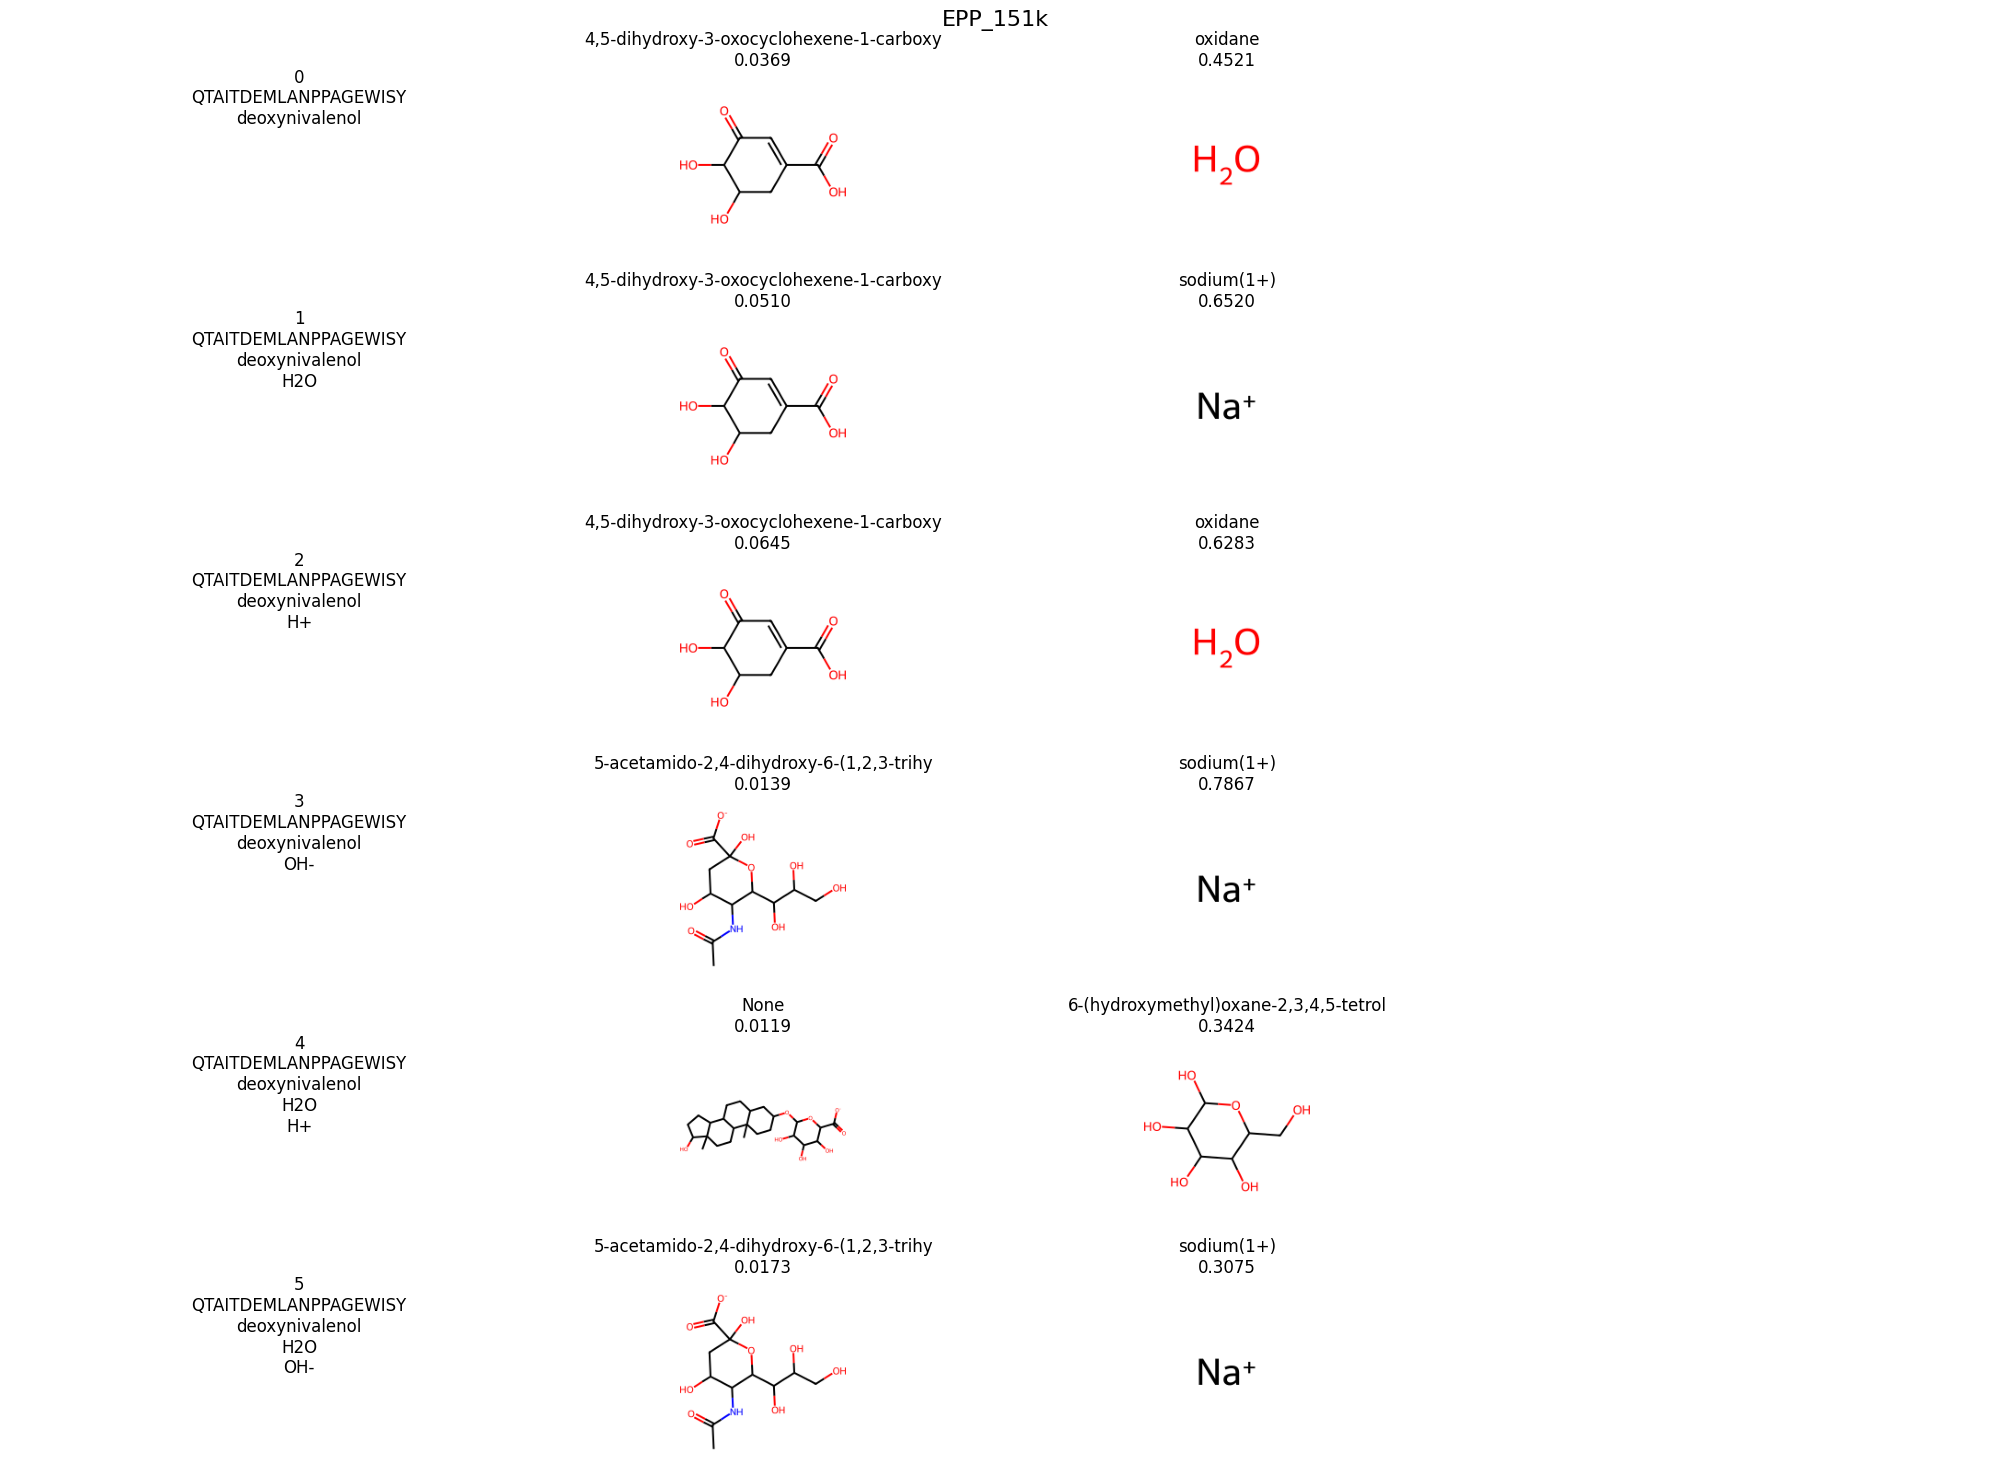

In [12]:
draw_mols_model(df_pred=df_pred01, model_name="EPP_151k")

保存添加分子结构图的模型预测结果为EXCEL文件
Save the model prediction results of added molecular structure diagrams as excel files

In [13]:
from rdkit.Chem import Draw
from openpyxl import Workbook
from io import BytesIO
import openpyxl

def smiles_to_excel(df, cols, path):
    '''
    在dataframe中添加分子结构图，并保存为EXCEL文件
    Add the molecular structure diagram to dataframe and save it as an excel file
    '''
    # 创建一个EXCEL
    # Create an EXCEL
    wb = Workbook()
    ws = wb.active
    
    # 添加标题行
    # Add title row
    img_cols = ['img_'+x for x in cols]
    titles = list(df.columns) + img_cols
    ws.append(titles)
    
    # 添加df
    # add dataframe
    for index, row in df.iterrows():
        ws.append(row.tolist())
                    
    # 生成SMILES的图像并添加到EXCEL
    # Generate SMILES structure diagrams and add them to EXCEL
    df01 = df[cols]
    arr_smiles_activate = np.empty([len(cols)])
    # 遍历SMILES列的行
    # Traverse the rows of SMILES column
    for i in range(df01.shape[0]):
        # 如果当前行与上一行的SMILES不一致
        # If the SMILES of the current line is inconsistent with the previous line
        if not (df01.iloc[i,:].values == arr_smiles_activate).all():
            arr_smiles_activate = df01.iloc[i,:].values
            for j in range(df01.shape[1]):
                smiles = df01.iloc[i,j]
                # 判断smiles是否有效
                # Determine whether smiles are valid
                if isinstance(smiles, str) and (smiles.strip()) and (smiles != '<pad>'):
                    # 生成化学分子的二维结构图
                    # Generate two-dimensional structure diagram of a chemical molecule
                    mol = Chem.MolFromSmiles(smiles)
                    img = Draw.MolToImage(mol)
                    
                    # 将图像转化为字节流
                    # Convert image to byte stream
                    img_byte_arr = BytesIO()
                    img.save(img_byte_arr, format='PNG')
                    img_byte_arr = img_byte_arr.getvalue()
                    
                    # 在EXCEL中插入图像
                    # Insert image into EXCEL
                    img_cell = ws.cell(row=i+2, column=len(df.columns)+j+1)
                    img = openpyxl.drawing.image.Image(BytesIO(img_byte_arr))
                    ws.add_image(img, img_cell.coordinate)
                
    # 保存excel文件
    # Save excel file
    wb.save(path)

In [14]:
smiles_to_excel(df=df_pred01, 
                cols=['reaction1_substrate1_y', 'reaction1_substrate2_y', 'reaction1_substrate3_y', 'product1_pred', 'product2_pred', 'product3_pred',],
                path='../data/data_20240701_pred01.xlsx'
                )

[15:27:14] WARNING: not removing hydrogen atom without neighbors
[15:27:14] WARNING: not removing hydrogen atom without neighbors
